# Notebooks to merge subject information from imaging, clinical assessments and other sources of data
## Groups: 'PD', 'Prodromal', 'SWEDD', 'Control', 'Phantom', 'GenReg Unaff'

In [1]:
# from pathlib import Path
import sys
proj_path_str='/scratch/mr_proc'
sys.path.append(proj_path_str)
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
from private_libs.private_utils import report_visit

#PATH
main_dir = Path(proj_path_str)
data_dir = main_dir / 'tab_data' 
#out_dir = Path("/output")

#ppmi_dcm_file = data_dir / 'ppmi_dicomInfo.tsv'           # Inormation from dicom headers.
ppmi_img_dl_file = data_dir / 'PPMI_3T_sdMRI_3_07_2022.csv'  # Inormation from download database.
ppmi_moca_file  = data_dir / 'Montreal_Cognitive_Assessment__MoCA_.csv'  # Inormation from download database.
ppmi_updrs3_file  = data_dir / 'MDS_UPDRS_Part_III.csv'  # Inormation from download database.
ppmi_dicom_file = data_dir / 'PPMI_dicomInfo.tsv'  # Inormation from download database.


# Read tabular information
ppmi_img_dl_data  = pd.read_csv(ppmi_img_dl_file, sep=',')
ppmi_img_col_sel = ['Image Data ID', 'Subject', 'Group', 'Sex', 'Age', 'Visit', 'Modality', 'Description']
# select imaging columns
ppmi_img_dl_data = ppmi_img_dl_data.loc[:, ppmi_img_col_sel].copy()
# select study groups
group_sel_list=['PD', 'Prodromal', 'SWEDD', 'Control']
ppmi_img_dl_data = ppmi_img_dl_data[ppmi_img_dl_data.Group.isin(group_sel_list)].copy()
# Get subject list and group information from imaging data
subject_group = ppmi_img_dl_data.loc[:, ['Subject','Group']].copy();
subject_group.groupby('Subject').agg(lambda x: set(x));
subject_group['Subject']=[int(x) for x in subject_group['Subject']]
# Get T1 and DTI data
sequence_str=['T1', 'MPRAGE', 'DTI']
ppmi_img_dl_data = ppmi_img_dl_data[(ppmi_img_dl_data['Description'].str.contains(sequence_str[0]))|(ppmi_img_dl_data['Description'].str.contains(sequence_str[1]))|(ppmi_img_dl_data['Description'].str.contains(sequence_str[2]))].copy()
# Get additional sequence information
protocol_seqs=ppmi_img_dl_data.Description.unique()

# read and select UPDRS-3data
ppmi_updrs3_data = pd.read_csv(ppmi_updrs3_file, sep=',')
updrs3_list= ['PATNO', 'EVENT_ID', 'NP3SPCH', 'NP3FACXP','NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR',
             'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR',
             'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT',
             'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR',
             'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'NP3TOT', 'NHY'];
other_updrs_list = ['DYSKPRES', 'DYSKIRAT'];
ppmi_updrs3_data=ppmi_updrs3_data.loc[:,updrs3_list].copy();

# read and select MOCA data
ppmi_moca_data   = pd.read_csv(ppmi_moca_file, sep=',')
moca_list= ['PATNO', 'EVENT_ID', 'MCAALTTM', 'MCACUBE', 'MCACLCKC', 'MCACLCKN', 'MCACLCKH', 'MCALION', 'MCARHINO',
            'MCACAMEL', 'MCAFDS', 'MCABDS', 'MCAVIGIL', 'MCASER7', 'MCASNTNC',
            'MCAVFNUM', 'MCAVF', 'MCAABSTR', 'MCAREC1', 'MCAREC2', 'MCAREC3',
            'MCAREC4', 'MCAREC5', 'MCADATE', 'MCAMONTH', 'MCAYR', 'MCADAY', 'MCAPLACE', 'MCACITY', 'MCATOT'];
ppmi_moca_data=ppmi_moca_data.loc[:,moca_list].copy();

## reading dicom header collection data
ppmi_dicom_data = pd.read_csv(ppmi_dicom_file, sep='\t')
#dicom_list = ['patient_id', 'patient_age', 'patient_sex', 'dim1', 'dim2', 'dim3', 'dim4', 'TR', 'TE', 'series_description', 'dcm_dir_name'];
#ppmi_dicom_data=ppmi_dicom_data.loc[:,dicom_list].copy()

220324-08:31:12,630 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.5.0


/usr/local/miniconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (10,17,18,19,20,21,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## PPMI Converion: from dicom to BIDS niftis with HeuDiConv_0.9.0 

***Due to the limitation of number of inodes on CC, PPMI data is splited into PPMI_1.zip on Beluga and PPMI_2.zip on Narval, the data will be merged after conversion.***

    1. Extract all the dicoms in a folder named PPMI: '''unzip PPMI.zip -d ~/scratch/'''
    2. Correct studyID problems (takes hours to finish, put into subject paralellization next time): '''python studyID_fixer.py --data PPMI'''
    3. '''heudiconv_run1.sh PPMI''' + '''heudiconv_run1.format PPMI'''
    4. '''heudiconv_run2.sh PPMI all''' + '''heudiconv_run2.format PPMI'''
    5. Merge PPMI from Beluga nad Narval.

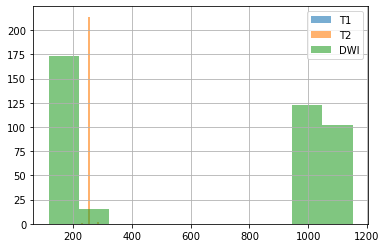

In [2]:
# the experiments on dicom header information includes find the exact field to filder the correct images, and check the dimentions of corresponding images.
# filter T1 with T1 or MPRAGE in series_description
from matplotlib import pyplot as plt 
ppmi_dicom_data[ppmi_dicom_data['series_description'].str.contains('T1|MPRAGE', regex=True)].dim1.hist(alpha=0.6, label='T1')
# filter T2 with T2 in series_description
ppmi_dicom_data[ppmi_dicom_data['series_description'].str.contains('T2')].dim1.hist(bins=10, alpha=0.6, label='T2')
# filter DTI with T1 in series_description
ppmi_dicom_data[ppmi_dicom_data['series_description'].str.contains('DTI')].dim1.hist(bins=10, alpha=0.6, label='DWI')
#plt.xlim([100,500])
plt.legend()

In [2]:
# reorganize PPMI Imaging data for easier query
tmp=ppmi_img_dl_data.groupby('Subject').agg(lambda x: list(x))
# get subject related features.
tmp['group'] = tmp['Group'].apply(lambda x: list(set(x))[0])
tmp['sex']   = tmp['Sex'].apply(lambda x: list(set(x))[0])
tmp['visit']  = tmp['Visit'].apply(lambda x: list(set(x)))
tmp['image_modality']  = tmp['Modality'].apply(lambda x: list(set(x)))
tmp['image_details'] =  tmp['Visit'].apply(lambda x: [str(y) for y in list(set(x))])
# get 
for x in tmp.index:
    tmp_str = ''
    for y in range(len(tmp.loc[x,'Visit'])):
        if y==0:
            tmp_str=str(tmp.loc[x,'Visit'][y])+'@'+str(tmp.loc[x,'Age'][y])+'@'+str(tmp.loc[x,'Modality'][y])+'@'+str(tmp.loc[x,'Image Data ID'][y])+'@'+str(tmp.loc[x,'Description'][y]);
        else:
            tmp_str=tmp_str+'+++'+str(tmp.loc[x,'Visit'][y])+'@'+str(tmp.loc[x,'Age'][y])+'@'+str(tmp.loc[x,'Modality'][y])+'@'+str(tmp.loc[x,'Image Data ID'][y])+'@'+str(tmp.loc[x,'Description'][y]);
    tmp.loc[x,'image_details']=tmp_str
ppmi_img_dl_data=tmp.drop(columns=['Image Data ID','Visit','Sex','Age','Group','Modality','Description'])

# subjects with MRI&DTI
tmp_imaging = ppmi_img_dl_data.copy()
tmp_imaging['filter_modality'] = tmp_imaging['image_modality'].apply(lambda x: x if len(x)>1 else np.nan).copy()
tmp_imaging=tmp_imaging.dropna()
tmp_imaging['img_visit']=tmp_imaging['visit']
tmp_imaging=tmp_imaging.drop(columns=['image_modality','image_details','filter_modality','visit'])

In [3]:
## preproc of tabular data
clinical_visit = ['BL', 'V04', 'V06', 'V08', 'V10', 'V12', 'V14', 'V15', 'V17', 'SC',
                  'V01', 'V02', 'V03', 'V05', 'V07', 'V09', 'V11', 'ST', 'V13',
                  'V16', 'PW', 'RS1', 'R17', 'R16', 'R15', 'V18', 'U01', 'R18',
                  'R14', 'R13', 'R08', 'R12', 'R06', 'R10', 'R04', 'R01'];
# visit: V01: 1,2,3    remote visit: R17:-17  Unscheduled visit: U01, -100
# screening:SC: -110 , RS1: rescreening, -111; RS2 rescreening, -112
# ST:Symptomatic Therapy -1000, 
# PW: Premature Withdrawal = -10000
unified_visit = [0, 4, 6, 8, 10, 12, 14, 15, 17, -110,
                 1, 2, 3, 5, 7, 9, 1, -1000, 13,
                 16, -10000, -111, -17, -16, -15, 18, -100, -18,
                 -14, -13, -8, -12, -6, -10, -4, -1];
visit_dict = dict(zip(clinical_visit, unified_visit))

# subjects with UPDRS
tmp_updrs3=ppmi_updrs3_data[['PATNO','EVENT_ID']].copy()
tmp_updrs3['Visit']=tmp_updrs3.EVENT_ID.apply(lambda x: visit_dict[x]);
tmp_updrs3=tmp_updrs3[tmp_updrs3['Visit']>0].copy(); tmp_updrs3['Subject']=tmp_updrs3['PATNO'];
tmp_updrs3 = tmp_updrs3.groupby('Subject').agg(lambda x: list(x)).copy()
tmp_updrs3['updrs3_visit']=tmp_updrs3['Visit'].apply(lambda x: list(set(x)))
tmp_updrs3=tmp_updrs3.drop(columns=['PATNO', 'EVENT_ID', 'Visit']).copy()
tmp_updrs3.index=[str(x) for x in tmp_updrs3.index]
# subjects with MOCA
tmp_moca = ppmi_moca_data
tmp_moca=ppmi_moca_data[['PATNO','EVENT_ID']].copy()
tmp_moca['Visit']=tmp_moca.EVENT_ID.apply(lambda x: visit_dict[x]);
tmp_moca=tmp_moca[tmp_moca['Visit']>0].copy(); tmp_moca['Subject']=tmp_moca['PATNO'];
tmp_moca = tmp_moca.groupby('Subject').agg(lambda x: list(x)).copy()
tmp_moca['moca_visit']=tmp_moca['Visit'].apply(lambda x: list(set(x)))
tmp_moca=tmp_moca.drop(columns=['PATNO', 'EVENT_ID', 'Visit']).copy()
tmp_moca.index=[str(x) for x in tmp_moca.index]

In [4]:
tmp_all=tmp_imaging.join([tmp_updrs3, tmp_moca], how='left');
tmp_all=tmp_all.dropna()
#print(tmp_all.img_visit)
#print(tmp_all.updrs3_visit)
#print(tmp_all.moca_visit)
tmp_all

,group,sex,img_visit,updrs3_visit,moca_visit
Subject,,,,,
14426,Prodromal,M,"[1, 7]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[8, 10, 4, 6]"
16644,Prodromal,M,"[1, 5, 7]","[1, 2, 3, 4, 6, 7, 8, 13]","[8, 4, 6]"
17608,Prodromal,M,[1],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]","[4, 6, 8, 10, 12, 13, 14]"
3101,SWEDD,M,"[1, 7]","[1, 2, 3, 4, 5, 6]","[4, 6]"
3102,PD,M,"[1, 21, 7]","[1, 2, 3, 5, 6, 7, 8, 9, 10]","[8, 10, 6]"
...,...,...,...,...,...
75512,Prodromal,F,[1],"[8, 2, 4, 6]","[8, 4]"
75525,Prodromal,F,[7],"[8, 6]","[8, 4, 6]"
75564,Prodromal,F,[1],"[2, 4, 6]","[4, 6]"


In [20]:
tmp_all_test=tmp_all.copy()
for x in tmp_all_test.index:
    tmp_=list(set.intersection(set(tmp_all_test.loc[x,'img_visit']),set(tmp_all_test.loc[x, 'updrs3_visit']),set(tmp_all_test.loc[x, 'moca_visit'])))
    if len(tmp_)==0:
        tmp_all_test.loc[x, 'visit_comm'] = np.nan;
    else:
        tmp_all_test.loc[x, 'visit_comm'] = [str(x) for x in tmp_]
tmp_all_test=tmp_all_test.dropna()
tmp_all_test

,group,sex,img_visit,updrs3_visit,moca_visit,visit_comm
Subject,,,,,,
85242,Prodromal,M,"[1, 5, 7]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]","[1, 4, 6, 8, 10, 12, 13, 14]",1
